In [80]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.metrics import accuracy_score

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

# 6. прочее
import random

In [2]:
class FeatureGenerator:
    def __init__(self):
        self.district_size = None
        self.med_price_by_district = None
        self.med_price_by_district_median = None
        self.floor_max = None
        self.floor_min = None
        self.house_year_max = None
        self.house_year_min = None
        self.med_price_by_floor_year = None
        self.med_price_by_floor_year_median = None
        
    def fit(self, df):
        X = df.copy()
        
        # District, Rooms
        if 'Price' in df:
            self.med_price_by_district = X.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
        
        # floor, year
        if 'Price' in df:
            self.floor_max = X['Floor'].max()
            self.floor_min = X['Floor'].min()
            self.house_year_max = X['HouseYear'].max()
            self.house_year_min = X['HouseYear'].min()
            X = self.floor_to_cat(X)
            X = self.year_to_cat(X)
            self.med_price_by_floor_year = X.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
    
    def transform(self, df):
        df['Room_square_share'] = df['Square'] / df['Rooms'] * 100
        
        df = self.floor_to_cat(df)  # столбец floor_cat
        df = self.year_to_cat(df)   # столбец year_cat
        
        # MedPriceByDistrictRoom
        if self.med_price_by_district is not None:
            df = df.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            df['MedPriceByDistrict'].fillna(self.med_price_by_district['MedPriceByDistrict'].median(), inplace=True)
         
        # MedPriceByFloorYear
        if self.med_price_by_floor_year is not None:
            df = df.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            df['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
            
        return df
    
    def floor_to_cat(self, X):
        bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

In [3]:
class DataPipeline:
    def __init__(self):
        self.medians = None
        self.kitchen_square_quantile = None
        self.district_size = None
        
    def fit(self, df):
        self.medians = df.median()
        self.district_size = df['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
         
    def transform(self, df):
        #
        # 1. выбросы
        #
        #Rooms
        df['Rooms_outlier'] = 0
        df.loc[(df['Rooms'] == 0) | (df['Rooms'] >= 6) | (df['Rooms'].isna()), 'Rooms_outlier'] = 1
        df.loc[df['Rooms'] == 0, 'Rooms'] = 1
        df.loc[(df['Rooms'] >= 6) | (df['Rooms'].isna()), 'Rooms'] = df['Rooms'].median()
        
        #Square
        square_min_value = np.quantile(df['Square'], q=0.025)
        square_max_value = np.quantile(df['Square'], q=0.975)
        df.loc[((df['Square'] > square_max_value) | (df['Square'] < square_min_value)), 'Square'] = self.medians['Square']
        
        #KitchenSquare
        square_max_value = np.quantile(df['KitchenSquare'], q=0.975)
        df.loc[((df['KitchenSquare'] > square_max_value) | (df['KitchenSquare'].isna())), 'KitchenSquare'] =\
            self.medians['KitchenSquare']
        df.loc[df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        #LifeSquare
        cond = df['LifeSquare'] > df['Square']
        df.loc[cond, 'LifeSquare'] = df.loc[cond, 'Square'] - df.loc[cond, 'KitchenSquare'] - 3
        
        #HouseFloor & Floor  
        df['HouseFloor_outlier'] = 0
        df.loc[df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = df.loc[df['Floor'] > df['HouseFloor']].index
        df.loc[floor_outliers, 'Floor'] = df.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        #HouseYear
        df.loc[df['HouseYear'] > 2020, 'HouseYear'] = 2020
        
        #
        # 2. пропуски
        #
        #LifeSquare
        df['LifeSquare_nan'] = df['LifeSquare'].isna() * 1
        condition = (df['LifeSquare'].isna()) & \
                      (~df['Square'].isna()) & \
                      (~df['KitchenSquare'].isna())
        df.loc[condition, 'LifeSquare'] = df.loc[condition, 'Square'] - df.loc[condition, 'KitchenSquare'] - 3
        
        #Healthcare_1
        df['Healthcare_1_nan'] = df['Healthcare_1'].isna() * 1
        df['Healthcare_1'].fillna(self.medians['Healthcare_1'], inplace=True)
        
        #
        # 3. drop id
        #
        df.drop(columns=['Id'], inplace=True)
        
        #
        # 4. Обработка категорий
        #
        df.loc[df['Ecology_2'] == 'A','Ecology_2'] = 1
        df.loc[df['Ecology_2'] == 'B','Ecology_2'] = 0

        df.loc[df['Ecology_3'] == 'A','Ecology_3'] = 1
        df.loc[df['Ecology_3'] == 'B','Ecology_3'] = 0

        df.loc[df['Shops_2'] == 'A','Shops_2'] = 1
        df.loc[df['Shops_2'] == 'B','Shops_2'] = 0
        
        # DistrictId, IsDistrictLarge
        df = df.merge(self.district_size, on='DistrictId', how='left')
        
        df['new_district'] = 0
        df.loc[df['DistrictSize'].isna(), 'new_district'] = 1
        
        df['DistrictSize'].fillna(5, inplace=True)
        
        df['IsDistrictLarge'] = (df['DistrictSize'] > 100).astype(int)
              
        df.fillna(self.medians, inplace=True)
        
        return df
    
    
    
    def save(self, df, path):
        df.to_csv(path, index=False, encoding='utf-8')
        print('saved')

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [39]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'
PREPARED_DATASET_PATH_TRAIN = './train_prepared.csv'
PREPARED_DATASET_PATH_TEST = './test_prepared.csv'

# train dataset
df = pd.read_csv(TRAIN_DATASET_PATH)
pipe = DataPipeline()
pipe.fit(df)
df = pipe.transform(df)

gen = FeatureGenerator()
gen.fit(df)
df = gen.transform(df)

df = reduce_mem_usage(df)
pipe.save(df, PREPARED_DATASET_PATH_TRAIN)

# test dataset
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df = pipe.transform(test_df)

test_df = gen.transform(test_df)

test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 2.33 MB
Memory usage after optimization is: 0.79 MB
Decreased by 66.0%
saved
Memory usage of dataframe is 1.13 MB
Memory usage after optimization is: 0.39 MB
Decreased by 65.6%


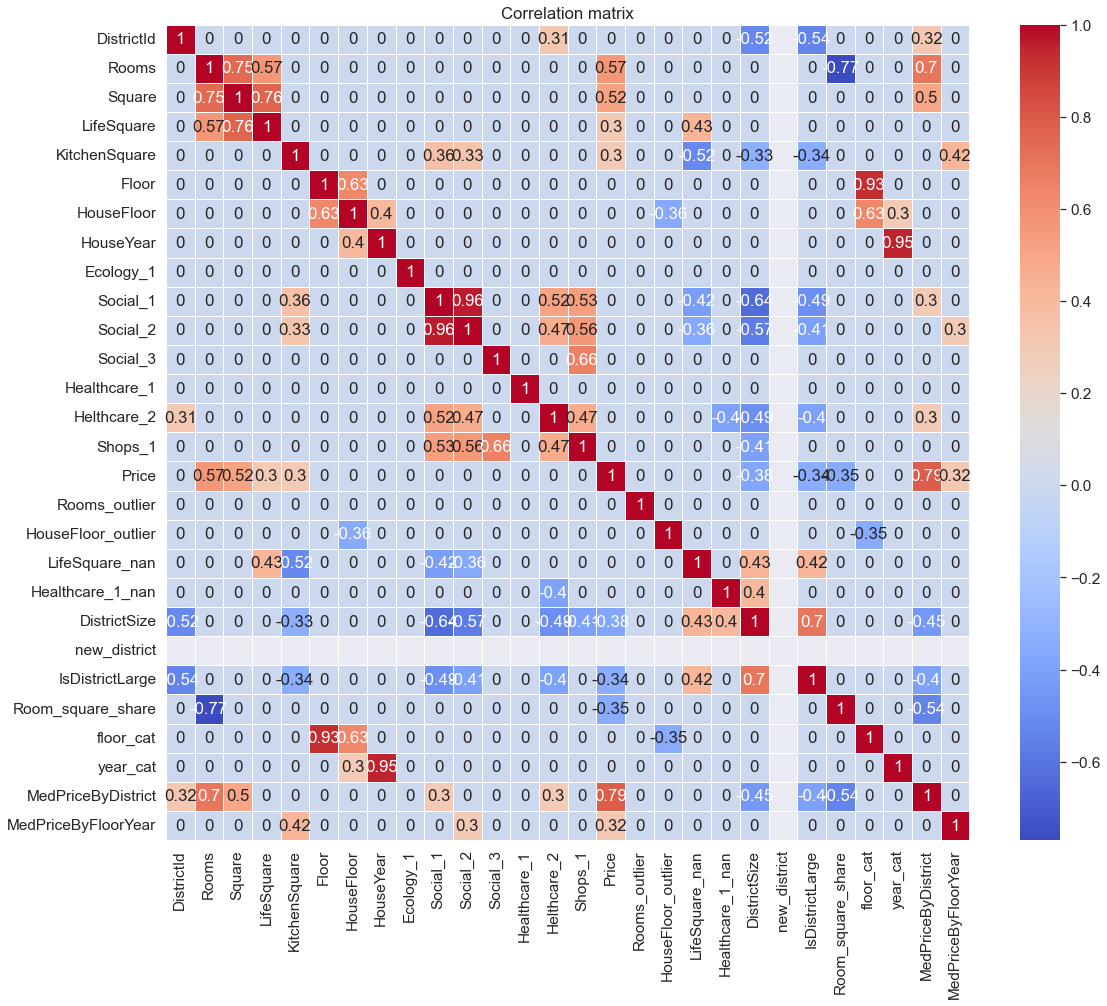

In [6]:
# матрица кореляций
plt.figure(figsize=(18, 15))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

# видим, что есть три похожих признака, которые сильно скоррелированы и будут нам мешать при обучении линейной регрессии,
# поэтому можем пользоваться нелинейным признаком Rooms_square_share

In [103]:
# разделение на test и train
def prepare_test_valid(df, columns_to_drop = ['Price']):
    X = df.drop(columns=columns_to_drop)
    y = df['Price']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)
    return X_train, X_valid, y_train, y_valid

In [92]:
# разделение на test и train
X_train, X_valid, y_train, y_valid = prepare_test_valid(df)
X_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,LifeSquare_nan,Healthcare_1_nan,DistrictSize,new_district,IsDistrictLarge,Room_square_share,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear
8371,70,3.0,72.593849,72.032387,7.0,15,16.0,1976,0.002212,0,...,0,1,27,0,0,2419.794922,3.0,2.0,340422.750000,183400.656250
5027,24,2.0,38.427761,26.170250,6.0,3,12.0,1969,0.111627,0,...,0,0,35,0,0,1921.388062,0.0,2.0,274219.687500,182214.421875
9234,13,2.0,59.198891,35.928226,10.0,7,17.0,1999,0.090799,0,...,0,1,97,0,0,2959.944580,2.0,3.0,241068.906250,228134.765625
3944,113,2.0,38.128403,23.055471,6.0,7,14.0,1970,0.050756,0,...,0,0,41,0,0,1906.420166,2.0,2.0,216242.234375,192984.062500
6862,27,1.0,40.490421,4.114601,3.0,20,22.0,2019,0.211401,0,...,0,1,851,0,1,4049.041992,4.0,5.0,118349.679688,210878.531250


In [11]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8, 8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [138]:
def show_feature_importances(X, model):
    feature_importances = pd.DataFrame(zip(X.columns, model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

    print(feature_importances.sort_values(by='importance', ascending=False))

In [126]:
# метрика R2 для разных моделей
# LinearRegression - 0.669
# DecisionTree - 0.647
# Gradient boosting - 0.662
# Random forrest:

In [132]:
%%time
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=20, 
                                 min_samples_leaf=30,
                                 random_state=42, 
                                 n_estimators=100
                                 )
params = {'max_depth':[10, 20, 30, 40],
         'min_samples_leaf':[1, 2, 3, 4],
         'n_estimators':[300, 350, 400]}

gs = GridSearchCV(rf_model, params, 
                  scoring='r2',
                  cv=KFold(n_splits=5,
                           random_state=42, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

Wall time: 44.7 s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(criterion='mse', max_depth=20,
                                             min_samples_leaf=30,
                                             random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [20], 'min_samples_leaf': [2],
                         'n_estimators': [300, 350, 400]},
             scoring='r2')

In [133]:
gs.best_params_

{'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 350}

R2:	0.72
RMSE:	50770.005
MSE:	2577593383.181


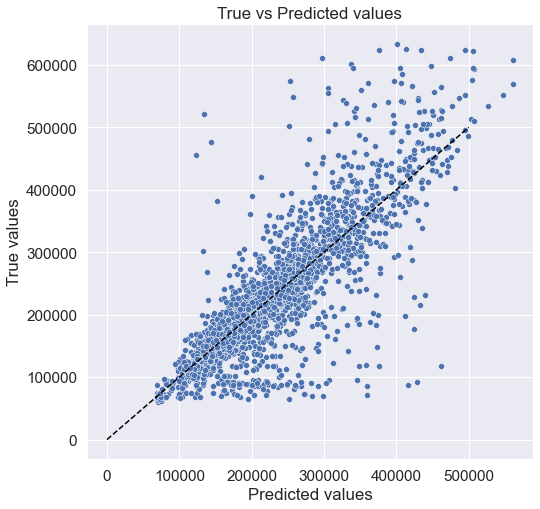

In [134]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=20,
                                 min_samples_leaf=2,
                                 random_state=42, 
                                 n_estimators=350
                                 )
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_valid)
evaluate_preds(y_valid, preds)

In [139]:
show_feature_importances(X_train, rf_model)

           feature_name  importance
28   MedPriceByDistrict    0.658879
2                Square    0.063165
25    Room_square_share    0.052402
3            LifeSquare    0.025532
29  MedPriceByFloorYear    0.023345
7             HouseYear    0.023226
6            HouseFloor    0.020667
22         DistrictSize    0.015687
13             Social_3    0.013171
4         KitchenSquare    0.013083
8             Ecology_1    0.012709
5                 Floor    0.011573
12             Social_2    0.011464
0            DistrictId    0.010904
11             Social_1    0.010790
14         Healthcare_1    0.010414
16              Shops_1    0.006841
15          Helthcare_2    0.005135
26            floor_cat    0.002869
19   HouseFloor_outlier    0.001951
27             year_cat    0.001481
1                 Rooms    0.001124
21     Healthcare_1_nan    0.001054
20       LifeSquare_nan    0.000918
17              Shops_2    0.000703
10            Ecology_3    0.000476
24      IsDistrictLarge    0

In [ ]:
# Модель случайного леса показала наилучший результат.
# Так же обучение без MedPriceByDistrict показало худший результат.
# sample submission

In [160]:
preds = pd.Series(rf_model.predict(test_df))
preds

0       159629.624297
1       122080.870361
2       140632.634666
3       177143.826046
4       178578.862256
            ...      
4995    180126.330197
4996    362811.689176
4997    147343.690805
4998    179518.860749
4999    268250.255195
Length: 5000, dtype: float64

In [175]:
ides = pd.read_csv(TEST_DATASET_PATH)['Id']
sample_submission = pd.merge(ides, preds.rename('Price'), left_index=True, right_index=True)
sample_submission

,Id,Price
0,4567,159629.624297
1,5925,122080.870361
2,960,140632.634666
3,3848,177143.826046
4,746,178578.862256
...,...,...
4995,10379,180126.330197
4996,16138,362811.689176
4997,3912,147343.690805
4998,5722,179518.860749


In [176]:
sample_submission.to_csv('sample_submission.csv', index=False)